<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies
!pip install deepbrain
!pip install pydicom
!pip install dicom2nifti

In [2]:
from google.colab import drive

# mount google drive into google colab
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os

# go to where the data is
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project')
os.listdir()

['.config', 'gdrive', 'sample_data']


['t1_scan', 'T1_SAG_SIEMEN_3T_CLEAN_5_29_2019.csv', 'T1_SAG_SIEMEN_3T_CLEAN_1']

In [0]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom

%matplotlib inline

**Exploring the Data**

In [5]:
# import data and show head
df = pd.read_csv('T1_SAG_SIEMEN_3T_CLEAN_5_29_2019.csv')
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,1130198,75422,GenCohort Unaff,M,73,1,MRI,MPRAGE GRAPPA,Original,11/13/2018,DCM,5/07/2019
1,1130190,75414,GenCohort Unaff,F,73,1,MRI,Sag MPRAGE GRAPPA,Original,12/13/2018,DCM,4/24/2019
2,1130191,75414,GenCohort Unaff,F,73,1,MRI,Sag MPRAGE GRAPPA,Original,12/13/2018,DCM,4/24/2019
3,1125041,74375,GenCohort Unaff,F,59,1,MRI,MPRAGE_GRAPPA,Original,9/06/2018,DCM,4/24/2019
4,1003469,72138,GenCohort Unaff,F,55,1,MRI,MPRAGE GRAPPA,Original,2/19/2018,DCM,4/24/2019


In [6]:
descriptions_array = df.Description.values
np.unique(descriptions_array, return_counts=True) # shows what the data looks like, we can take the GRAPPA exemplars

(array(['MPRAGE', 'MPRAGE GRAPPA', 'MPRAGE GRAPPA 2', 'MPRAGE GRAPPA_ND',
        'MPRAGE T1 SAG', 'MPRAGE w/ GRAPPA', 'MPRAGE_GRAPPA',
        'SAG MPRAGE GRAPPA', 'SAG T1 3D MPRAGE', 'Sag MPRAGE GRAPPA'],
       dtype=object),
 array([  5, 278,   1,   2,  14,  10,  16,  13,  34,   8]))

MPRAGE is magnetically prepared rapid gradient echo, with Generalized Autocalibrating Partially Parallel Acquisition GRAPPA to reconstruct intermediary lines and speed up acquisition process. We can join some of these together. Namely the GRAPPA and ND

In [0]:
# looks like a bunch of MPRAGE GRAPPA are mislabelled or slightly different, change these
dscrptn = df['Description'].replace({'MPRAGE w/ GRAPPA':'MPRAGE GRAPPA', 'MPRAGE_GRAPPA':'MPRAGE GRAPPA', 
                           'SAG MPRAGE GRAPPA':'MPRAGE GRAPPA', 'SAG T1 3D MPRAGE': 'MPRAGE GRAPPA', 
                                     'Sag MPRAGE GRAPPA':'MPRAGE GRAPPA'})

df['Description'] = dscrptn

In [8]:
np.unique(df.Description.values, return_counts=True) 

(array(['MPRAGE', 'MPRAGE GRAPPA', 'MPRAGE GRAPPA 2', 'MPRAGE GRAPPA_ND',
        'MPRAGE T1 SAG'], dtype=object), array([  5, 359,   1,   2,  14]))

Looks about right, decide to go with just the 'MPRAGE GRAPPA' as our first set, giving us 359 patients, no duplicates. Note that the GenCohort subject ID has 5 digits whilst the PD and control has digits, their image data id has 7 digits whilst the others have 6 digits. Something to be aware of.

In [9]:
df2 = df[df['Description']=='MPRAGE GRAPPA']
print (len(df2))
df2.head()

359


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,1130198,75422,GenCohort Unaff,M,73,1,MRI,MPRAGE GRAPPA,Original,11/13/2018,DCM,5/07/2019
1,1130190,75414,GenCohort Unaff,F,73,1,MRI,MPRAGE GRAPPA,Original,12/13/2018,DCM,4/24/2019
2,1130191,75414,GenCohort Unaff,F,73,1,MRI,MPRAGE GRAPPA,Original,12/13/2018,DCM,4/24/2019
3,1125041,74375,GenCohort Unaff,F,59,1,MRI,MPRAGE GRAPPA,Original,9/06/2018,DCM,4/24/2019
4,1003469,72138,GenCohort Unaff,F,55,1,MRI,MPRAGE GRAPPA,Original,2/19/2018,DCM,4/24/2019


In [10]:
# Change the object type to dates for date
df2['Acq Date'] = pd.to_datetime(df2['Acq Date'], format='%d/%M/%Y')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
df2.info() # just get understanding of types of data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 0 to 380
Data columns (total 12 columns):
Image Data ID    359 non-null int64
Subject          359 non-null int64
Group            359 non-null object
Sex              359 non-null object
Age              359 non-null int64
Visit            359 non-null int64
Modality         359 non-null object
Description      359 non-null object
Type             359 non-null object
Acq Date         359 non-null datetime64[ns]
Format           359 non-null object
Downloaded       128 non-null object
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 36.5+ KB


In [12]:
# count number with PD and number of controls
np.unique(df2.Group, return_counts=True)

(array(['Control', 'GenCohort PD', 'GenCohort Unaff', 'PD'], dtype=object),
 array([ 86,  33,  39, 201]))

In [0]:
# So keep only one scan per patient and use the most recent scans
df3 = df2.sort_values('Acq Date').drop_duplicates('Subject',keep='last')

In [14]:
# count number with PD and number of controls, drop duplicates and only have some left
np.unique(df3.Group, return_counts=True) # 337 patients

(array(['Control', 'GenCohort PD', 'GenCohort Unaff', 'PD'], dtype=object),
 array([ 85,  32,  38, 182]))

In [0]:
# looks merge the gencohort pd with pd and gencohortrol unaff with control
merginging = df3['Group'].replace({'GenCohort PD':'PD', 'GenCohort Unaff':'Control'})

df3['Group'] = merginging

In [16]:
np.unique(df3.Group, return_counts=True) # 337 patients

(array(['Control', 'PD'], dtype=object), array([123, 214]))

We can see that some patients have multiple scans and different dates. Treat these as independent occurances. 
<br>
Plan:
-  Get all subject ID's
-  Search these folders, if more than 1 subfolder, take the second which will be the TSE FS files
-  Then each scan subfolder is treated as an independent case (important to mention) as we have 412 patients but 729 scans i.e. some patients had more than one scan over time. Balance this out by just selecting one image per patient
    -  By one image per patient, it is meant that the last image is selected for classification, so we should have 412 images overall, balancing out the ratio slightly. Select the last one
    -  Problem with selecting the last one however is that it is the latest scan (most recent one), meaning it is more likely to be later stage PD in development. Meaning we may have a harder time diagnosing those with early stages of PD
    -  Way to go around this would be to train with the earliest stage of a classifier or use another MRI data source set

In [0]:
# establish control and pd df's
df_control = df3[df3.Group == 'Control'] # for control, keep duplicate subject n.o's
df_pd = df3[df3.Group == 'PD'] # so we keep duplicates for both groups anyhow

In [18]:
print ("Number of control patients: %d " % len(df_control))
print ("Number of PD patients: %d " % len(df_pd))

Number of control patients: 123 
Number of PD patients: 214 


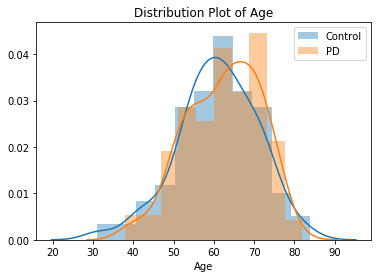

In [19]:
# seaborn distribution plot
sns.distplot(df_control.Age, rug=False, label='Control')
sns.distplot(df_pd.Age, rug=False, label='PD')
plt.title('Distribution Plot of Age')
plt.legend()
plt.show() # pd has a slightly older distribution than control

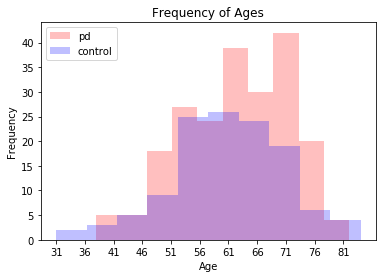

In [20]:
# plot for the ages
plt.hist(df_pd.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(df_control.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(df_control.Age), max(df_control.Age)+1, 5.0))
plt.show()

What can happen if we have too many PD compared to control? Without balancing (by only allowing one scan per patient, we reduce the ratio from 7:1 between PD to Control to about 1:5. If we just do this method for PD patients only, we can set the ratio to about 1:3 (which is what we will go with) so we have a balanced set to train as possible. Though it means we have less instances to train with.

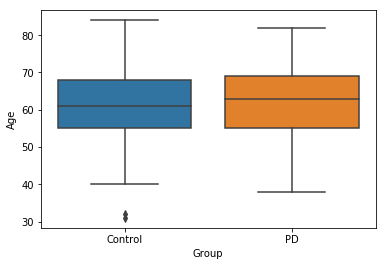

In [21]:
# some boxplots
ax = sns.boxplot(x="Group", y="Age", data=df3)

Similar age distributions for both groups but control has a few outliers, this shows that it could be useful using age and gender as a marker for PD perhaps.. For each, control and PD we can state the number of M and F in each.

In [22]:
print ("For Control:")
print (np.unique(df_control.Sex.values, return_counts=True))
print ("For PD")
print (np.unique(df_pd.Sex.values, return_counts=True)) # very visible from results males are more likely to get pd..

For Control:
(array(['F', 'M'], dtype=object), array([51, 72]))
For PD
(array(['F', 'M'], dtype=object), array([ 82, 132]))


##### Find the right subjects and image scan ID's and search files for these, build a list of directories to scan
Then build a corresponding datastructure.
-  Datastructure: Dictionary {Image_ID: List of DCM Files}

In [0]:
# Logic:
# First compile both control and PD into some super DF
# Then make a list of all the corresponding subject ID's
# Then make a list of all the corresponding Image ID's

# Loop through to get the right folders (one that match with subject ID)
# open the last subfolder (MRI TSE)
# open the last subfolder again ( most recent dated image )
# 's' + image_id is the subfolder to store
# store the path

# Then Store the list of DCM files 

# File Structure: msc_project/T1_3T_SAGITTAL_PT1/PPMI/*SUBJECT_ID*/MPRAGE_GRAPPA/DATE/*SCAN_ID*/*DCM FILES*
# Note that we only have 258 samples then if we do not have duplicates (better at first)

In [24]:
df_u = pd.concat([df_control, df_pd]) # df ultima
df_u = df_u.sample(frac=1) # randomly shuffle df
df_u.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
295,249434,3353,Control,F,56,1,MRI,MPRAGE GRAPPA,Original,2011-01-03 00:14:00,DCM,NaN
89,367428,4034,PD,F,55,1,MRI,MPRAGE GRAPPA,Original,2013-01-04 00:02:00,DCM,NaN
14,757838,54937,Control,F,84,1,MRI,MPRAGE GRAPPA,Original,2016-01-06 00:15:00,DCM,4/25/2019
363,305874,3122,PD,M,62,1,MRI,MPRAGE GRAPPA,Original,2012-01-05 00:09:00,DCM,NaN
67,437315,40800,PD,M,79,1,MRI,MPRAGE GRAPPA,Original,2014-01-03 00:12:00,DCM,5/07/2019


In [25]:
u_subject_id = df_u.Subject.values # gets the required ID's
u_subject_id[:25] # some have 5 digits, this is indicative that it is in gencohort group

array([ 3353,  4034, 54937,  3122, 40800, 42710,  4069, 50328,  3616,
        3300,  3564,  4012,  3625, 40534, 50319,  3771,  4139,  3386,
        4135,  3609,  3769,  3102,  3867,  3827, 50961])

**Now actually go to file with all the scans. This goes deep into just one scan, would do this for all scans and input into NN**

In [0]:
# os.chdir('ppmi_scans') # go to file with all the scans
os.chdir('t1_scan') # just go to test scan for now

In [27]:
subject_ids = os.listdir()
path = os.getcwd()
print (path)

/content/gdrive/My Drive/msc_project/t1_scan


In [0]:
def get_grappa_dir(path):
  # get the file ending with 'FS', would need to accomodate this for grappa also
  for next_path in os.listdir(path):
    if (next_path.split("_")[-1] == 'GRAPPA'): # for the t1 weighted
      return next_path

In [0]:
def get_dcm_s(path):
  # get the path beginning with S, so doesn't clash with GZ File
  for next_path in os.listdir(path):
    if (next_path[0] == 'S'):
      return next_path

In [30]:
# vertical then horizontal, go into first subject id
path_p1 = (path + '/' + str(subject_ids[0])) # get first id (this would be given from the list in pandas array)
path_p2 = (path_p1 + '/' + get_grappa_dir(path_p1)) # get the right GRAPPA file
path_p3 = (path_p2 + '/' + os.listdir(path_p2)[-1]) # get most recent scan
path_p4 = (path_p3 + '/' + get_dcm_s(path_p3)) # pick the scan beginning with s

os.listdir(path_p4)[:5] # dcm files (unordered)

['PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114204317_72_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114204691_73_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114204988_76_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114204879_71_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114204801_70_S193229_I377956.dcm']

In [31]:
print (path_p4)

/content/gdrive/My Drive/msc_project/t1_scan/4135/MPRAGE_GRAPPA/2013-03-01_14_34_50.0/S193229


In [32]:
dcm_files_test = os.listdir(path_p4) # get an individual dcom file
length_of_dcm = (len(dcm_files_test)) # get range length
print (length_of_dcm)

173


In [33]:
os.chdir(path_p4) # change the working dir to path p4 (where the dcm files are)
os.getcwd()

'/content/gdrive/My Drive/msc_project/t1_scan/4135/MPRAGE_GRAPPA/2013-03-01_14_34_50.0/S193229'

In [34]:
dcm_files_test[0] # just a random test, Great we have a .dcm file

'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114204317_72_S193229_I377956.dcm'

In [0]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets # interactive plots

In [0]:
# make it a function for a widget
def f(i):
    slices = pydicom.read_file(dcm_files_test[i]) # it is not ordered
    plt.imshow(slices.pixel_array)
    plt.show()
    return None

In [37]:
interact(f, i=14) # now we have a slidebar, woo! Covers all data values
# with t1 it is saggital

interactive(children=(IntSlider(value=14, description='i', max=42, min=-14), Output()), _dom_classes=('widget-…

<function __main__.f>

Problem: Need to order slices properly (all 173 of them)

In [0]:
def filename_sort(filename):
    
    # split by underlines and delimiter
    split_line = filename.split("_")
    int_return = int(split_line[-3])
    
    return int_return

Note: The 3 characer approach might not work for 1 character

In [39]:
sorted_slices = sorted(dcm_files_test, key=lambda filename: filename_sort(filename)) # some have length 3
sorted_slices[:5] # perfect, we have our ordered slices

['PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114214613_1_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114214691_2_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114214894_3_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114214956_4_S193229_I377956.dcm',
 'PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114214753_5_S193229_I377956.dcm']

In [0]:
# make it a function for a widget
def f(i):
    slices = pydicom.read_file(sorted_slices[i]) # ordered slices now
    plt.imshow(slices.pixel_array)
    plt.show()
    return None

In [41]:
interact(f, i=widgets.IntSlider(min=0,max=(len(sorted_slices)-1),step=1,value=0)) # now we have a sorted slidebar!, wooooo! Covers all data values

interactive(children=(IntSlider(value=0, description='i', max=172), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

In [42]:
# turn the slices array into a matrix for input into our deep learning model
# not sure if this step is entirely required for our deep learning as nibabel sorts this out for us
pixel_arrays = [(pydicom.read_file(s)).pixel_array for s in sorted_slices]
pixel_arrays = np.array(pixel_arrays)

print ("3D Pixel Arrays: %s" % (np.shape(pixel_arrays),))

3D Pixel Arrays: (173, 256, 240)


The above is then an example of obtaining one pixel array for one set of scans, we will then attach that to a key which has image_id. This will allow us to cross reference this to whether the patient has PD or not. The different images also have different numbers of slices, this is something we will have to consider. *Will we chop all to 48?*

#### Now try to skull strip and segment the brain tissue, we can use the example of pixel_arrays (Method 1 mask)

Found the problem space, will try to see if this works with deepbrain. Seems like problem is converting the image type

Made test file with nii file (after conversion with dicom2nifti #https://github.com/icometrix/dicom2nifti then using that and converting it. Then made another folder and dumped the files in there. (Perhaps should dump all into one common folder though. Also there is a good possibility that we lose the order of our images. So may need to re-order these in the file after sorting. Or apply the mask THEN re-order the files!

In [0]:
import nibabel as nb # write/process to some common neuroimaging file formats
from deepbrain import Extractor # Trying now, installing a bunch of packages..

In [44]:
os.getcwd()

'/content/gdrive/My Drive/msc_project/t1_scan/4135/MPRAGE_GRAPPA/2013-03-01_14_34_50.0/S193229'

In [0]:
def get_image_dir(path): # account for different image id lengths
  image_id_len = len(path.split("/")[-1])
  output = None
  if (image_id_len == 7):
    output = path[:-7]
  if (image_id_len == 8):
    output = path[:-8]
  
  return output

In [0]:
import dicom2nifti
import dicom2nifti.settings as settings

settings.disable_validate_slice_increment() # disable this increment

# Converting a directory with dicom files to nifti files
dicom_directory = os.getcwd()
output_folder = get_image_dir(dicom_directory) # put file in the folder superseding the most recent
dicom2nifti.convert_directory(dicom_directory, output_folder, compression=True, reorient=True)

In [47]:
print (output_folder)

/content/gdrive/My Drive/msc_project/t1_scan/4135/MPRAGE_GRAPPA/2013-03-01_14_34_50.0/


In [0]:
def get_gz_path(path):
  # get the file ending with 'gz'
  for next_path in os.listdir(path):
    if (next_path.split(".")[-1] == 'gz'):
      return next_path

In [49]:
os.chdir(output_folder)
os.listdir() # it is the first file on the list

['S193229', '10_mprage_grappa.nii.gz']

In [0]:
newdir = os.getcwd() + '/' + get_gz_path(output_folder) # go to the new folder

In [0]:
pa = pixel_arrays.copy() # just make a copy of the pixel array and run with this. no need for nifti

In [52]:
os.getcwd()

'/content/gdrive/My Drive/msc_project/t1_scan/4135/MPRAGE_GRAPPA/2013-03-01_14_34_50.0'

In [53]:
# Load a nifti as 3d numpy image [H, W, D]
img = nb.load(newdir).get_fdata() # loads it even as a gz file

ext = Extractor()

# `prob` will be a 3d numpy image containing probability 
# of being brain tissue for each of the voxels in `img`
prob = ext.run(img) # img 

# mask can be obtained as:
mask = prob > 1e-3 # may have to adjust this value, make a mask out of it, 1e-3 seems to do well

Instructions for updating:
Use tf.gfile.GFile.


In [54]:
np.shape(mask)

(173, 240, 256)

In [55]:
np.shape(img)

(173, 240, 256)

In [0]:
img[~mask] = 0 # apply the mask itself

In [0]:
from scipy import ndimage

In [0]:
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    rotated_img = ndimage.rotate(img[i], 90)
    plt.imshow(rotated_img)
    plt.show()
    return None

In [59]:
interact(g, i=widgets.IntSlider(min=0,max=(len(img)-1),step=1,value=0)); # now we have a sorted slidebar!, wooooo! Covers all data values

interactive(children=(IntSlider(value=0, description='i', max=172), Output()), _dom_classes=('widget-interact'…

In [60]:
# we do not need the first 16 and 156 onwards, can remove these
img = img[17:156, :, :]
np.shape(img)

(139, 240, 256)

In [0]:
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    rotated_img = ndimage.rotate(img[i], 90)
    plt.imshow(rotated_img)
    plt.show()
    return None

In [62]:
interact(g, i=widgets.IntSlider(min=0,max=(len(img)-1),step=1,value=0)); # now we have a sorted slidebar!, wooooo! Covers all data values

interactive(children=(IntSlider(value=0, description='i', max=138), Output()), _dom_classes=('widget-interact'…

Mask works, but skull stripping doesn't seem to effective at all.. Rather shite, Mostly for T1:  So switch to T1 Dataset... Run POC with 10 exemplars first: https://pypi.org/project/deepbrain/

<br>
    Paper comparing methods for skull stripping: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4879034/

Now we have 173 slices for T1. Is there any axial t1 datasets?

**Now we can try and augment. Though is it possible to flip it and view the axial plane from the Sagittal Image?~**

In [0]:
img_transpose2 = img.transpose((1,2,0)) # more promising rotation, we move to axial plane
img_transpose_original = pixel_arrays.transpose((1,2,0)) # DOES NOT NEED ELABORATE LOADING & FILE STRUCTURE!

In [0]:
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    rotated_img = ndimage.rotate(img_transpose2[i], 0) # no need for rotation here
    plt.imshow(rotated_img)
    plt.show()
    return None

In [65]:
interact(g, i=widgets.IntSlider(min=0,max=(len(img)-1),step=1,value=0)); # plots our axial view, this is it

interactive(children=(IntSlider(value=0, description='i', max=138), Output()), _dom_classes=('widget-interact'…

In [0]:
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    rotated_img = ndimage.rotate(img_transpose_original[i], 0) # just get the original one for comparison
    plt.imshow(rotated_img)
    plt.show()
    return None

In [67]:
interact(g, i=widgets.IntSlider(min=0,max=(len(img_transpose_original)-1),step=1,value=0)); # plots our axial view, this is it

interactive(children=(IntSlider(value=0, description='i', max=255), Output()), _dom_classes=('widget-interact'…

In [0]:
img_transpose_original=img_transpose_original[35:180,:,:] # slice out parts that have no information

In [0]:
# try mask on the above after matrix op
ext = Extractor()

# `prob` will be a 3d numpy image containing probability 
# of being brain tissue for each of the voxels in `img`
prob = ext.run(img_transpose_original)  # confirms we do not even need to make a TAR file, can redesign our system

# mask can be obtained as:
mask = prob > 1e-3 # may have to adjust this value, make a mask out of it, 1e-3 seems to do well

In [0]:
img_transpose_original[~mask] = 0 # apply the mask itself

In [71]:
interact(g, i=widgets.IntSlider(min=0,max=(len(img_transpose_original)-1),step=1,value=90)); # plots our axial view, this is it

interactive(children=(IntSlider(value=90, description='i', max=144), Output()), _dom_classes=('widget-interact…

**Now we have IMG transpose original, let's augment this and plot the two sidebyside (take slice 100 cause triple digits). Also consider whether to feed into NN as grayscale or not (apply grayscale transformation to reduce computational complexity)**

In [0]:
flipped_image = np.flip(img_transpose_original[70,:,:], 1) # got this flipped. Works

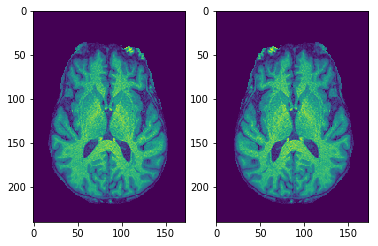

In [73]:
plt.subplot(1, 2, 1)
plt.imshow(img_transpose_original[70,:,:])

plt.subplot(1, 2, 2)
plt.imshow(flipped_image)

In [0]:
image_transpose_flipped = []
for i in range(len(img_transpose_original)):
  image_transpose_flipped.append(np.flip(img_transpose_original[i,:,:], 1))
  
image_transpose_flipped = np.array(image_transpose_flipped)

In [0]:
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    rotated_img = ndimage.rotate(image_transpose_flipped[i], 0) # just get the original one for comparison
    plt.imshow(rotated_img)
    plt.show()
    return None

In [80]:
interact(g, i=widgets.IntSlider(min=0,max=(len(image_transpose_flipped)-1),step=1,value=70)); # we have our flipped array

interactive(children=(IntSlider(value=70, description='i', max=144), Output()), _dom_classes=('widget-interact…

**We have two images, try and feed these into our first NN**

In [81]:
print ("Original Shape: %s " % (np.shape(img_transpose_original),))
print ("Flipped Shape: %s " % (np.shape(image_transpose_flipped),))

Original Shape: (145, 240, 173) 
Flipped Shape: (145, 240, 173) 
